In [1]:
source(file = "R/packages.R")
source(file = "R/multiplots.R")
source(file = "R/variables.R")
source(file = "R/utils.R")
source(file = "R/plots.R")

library(ggplot2)
library(xtable)
library(ellipse)
library(reshape)
library(digest)
library(scales)
library(cliffsd)

In [ ]:
distalLocationAll = r'/Volumes/Second_HD/GIT_DIR_2/cs846-Project/data-new.csv'

In [4]:
 mydata = read.csv("../data-new.csv")

In [6]:
all = mydata

# Main Analysis

In [7]:
#  Number of projects per language
for(language in c("javascript", "ruby", "java", "python", "scala")) {
  printf("%d projects in %s", length(unique(subset(all, lang == language)$project_name)), language)
}

[1] "1726 projects in javascript"
[1] "1086 projects in ruby"
[1] "1075 projects in java"
[1] "1518 projects in python"
[1] "138 projects in scala"


In [9]:
# Number of pullrequests per language
for(language in c("javascript", "ruby", "java", "python", "scala")) {
  printf("%d pullreqs %s", nrow(subset(all, lang == language)), language)
}


[1] "266294 pullreqs javascript"
[1] "168534 pullreqs ruby"
[1] "124069 pullreqs java"
[1] "315258 pullreqs python"
[1] "41910 pullreqs scala"


In [15]:
# Columns used in building models
columns = c("team_size", "num_commits", "files_changed",
            "perc_external_contribs", "sloc", "src_churn", "test_churn",
            "commits_on_files_touched", "test_lines_per_kloc",
            "prev_pullreqs", "requester_succ_rate", "num_comments")

In [16]:
merged <- subset(all, merged == TRUE)
non_merged <- subset(all, merged == FALSE)

# Descriptive statistics accross all projects
used <- subset(all, select=columns)

## Percentage of merged vs unmerged pull requests accross projects


In [11]:
library(sqldf)

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite


In [12]:
a <- all
merged.perc <- sqldf("select project_name, (select count(*) from a a1 where a1.project_name = a.project_name and merged = 'TRUE') *1.0/ (select count(*) from a a1 where a1.project_name = a.project_name) as ratio_merged from a group by project_name order by ratio_merged")
merged.perc$order = as.numeric(rownames(merged.perc))

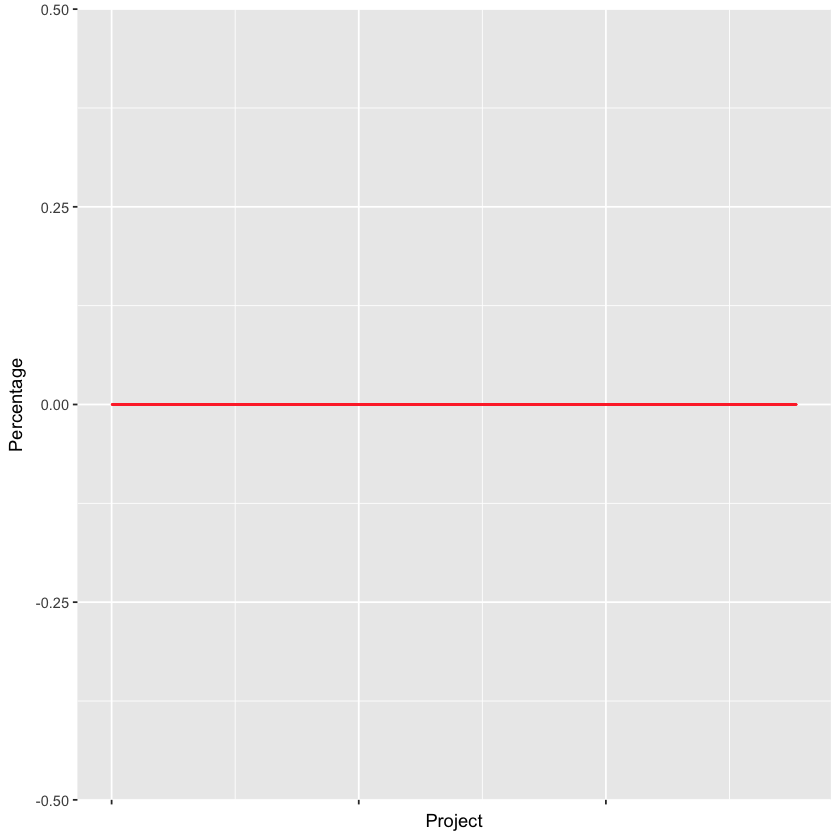

In [13]:
ggplot(merged.perc, aes(x = order, y = ratio_merged)) +
  geom_bar(stat="identity", color = "#ff3333") +
  theme(axis.text.x=element_blank()) +
  ylab("Percentage") +
  xlab("Project")

Warning message:
“Transformation introduced infinite values in continuous x-axis”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 70378 rows containing non-finite values (stat_bin).”

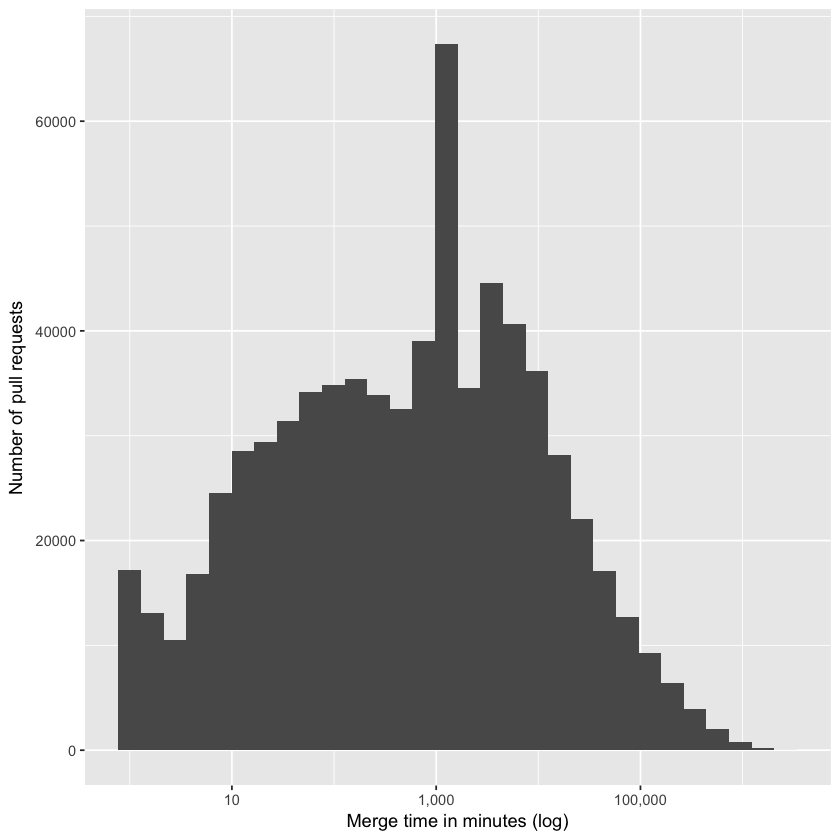

In [17]:
# Time to merge pull request box plots histogram
ggplot(merged, aes(x = mergetime_minutes)) +
  geom_histogram() + scale_x_log10(labels=comma) +
  xlab("Merge time in minutes (log)") +
  ylab("Number of pull requests")

In [18]:
# Size of pull request patch
all$size <- all$src_churn + all$test_churn

Warning message:
“Transformation introduced infinite values in continuous x-axis”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 176191 rows containing non-finite values (stat_bin).”

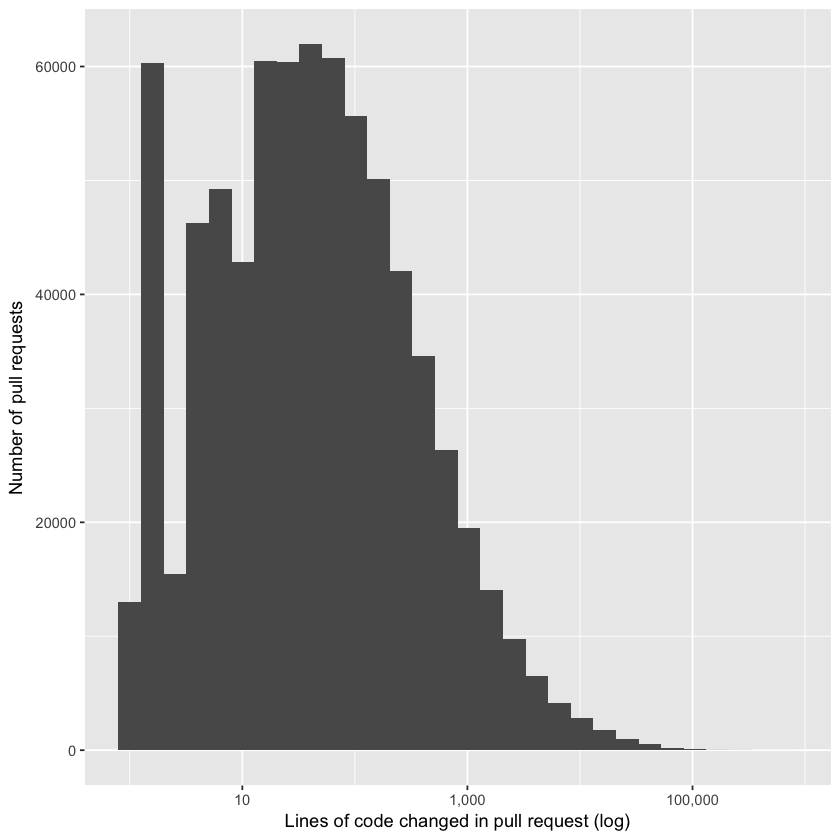

In [19]:
ggplot(all, aes(x = size)) +
  geom_histogram() + scale_x_log10(labels=comma) +
  xlab("Lines of code changed in pull request (log)") +
  ylab("Number of pull requests")

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 5939 rows containing non-finite values (stat_bin).”

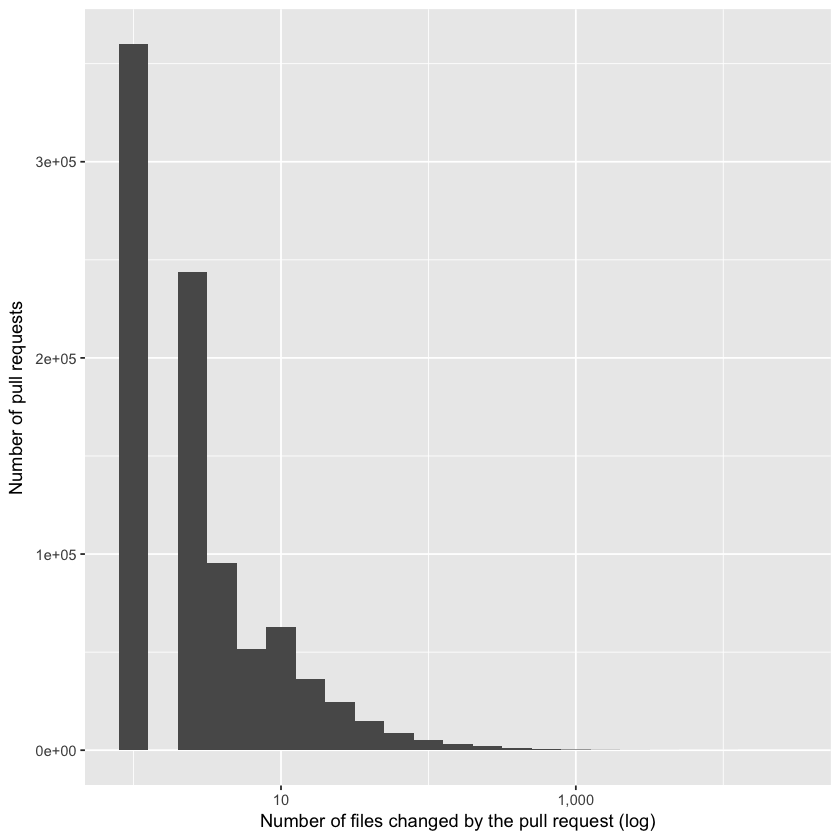

In [20]:
# Size of pull request - files touched
ggplot(all, aes(x = files_changed)) +
  geom_histogram(binwidth = 0.2) + scale_x_log10(labels=comma) +
  xlab("Number of files changed by the pull request (log)") +
  ylab("Number of pull requests")

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 411137 rows containing non-finite values (stat_bin).”

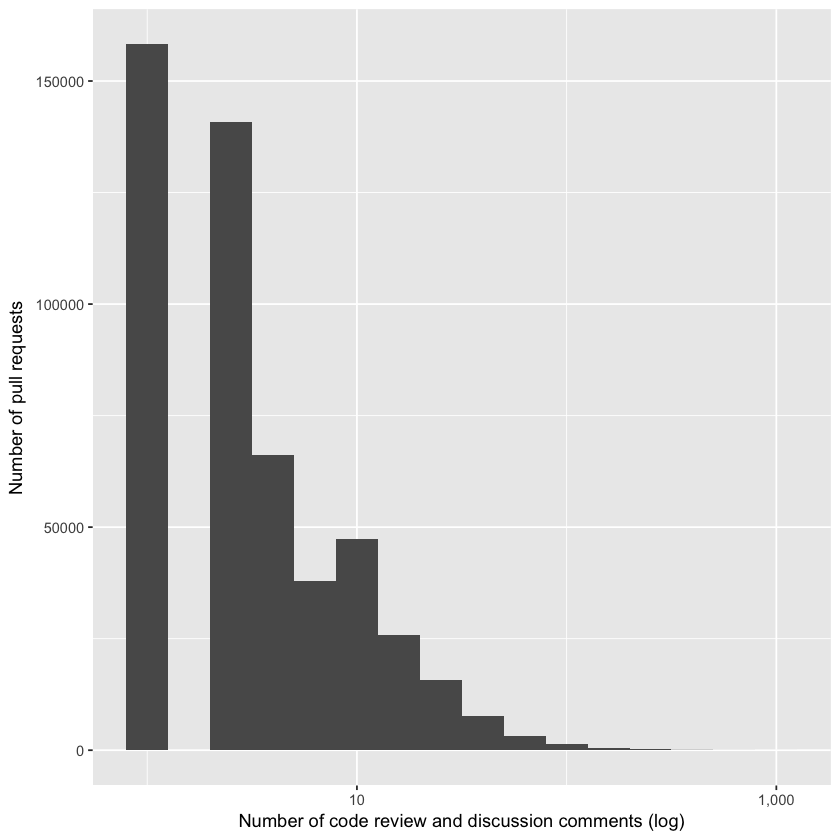

In [21]:
# Size of pull request comments
ggplot(all, aes(x = num_comments)) +
  geom_histogram(binwidth = 0.2) + scale_x_log10(labels=comma) +
  xlab("Number of code review and discussion comments (log)") +
  ylab("Number of pull requests")

# Dataset descriptive statistics

## Average Merged


In [22]:
# Merge % overall
printf("Avg pullreq merged: %f", (nrow(merged)/nrow(all))*100)

[1] "Avg pullreq merged: 84.873781"


## Merged Pulled Quantiles


In [25]:
# Merged pull reqs quantiles
to.days <- function(x) {
  x / 60 / 24
}
printf("Merge time in days quantiles: 95: %f, 90: %f, 80: %f",
        to.days(quantile(merged$mergetime_minutes, 0.95)),
        to.days(quantile(merged$mergetime_minutes, 0.90)),
        to.days(quantile(merged$mergetime_minutes, 0.80)))

merged.fast <- subset(merged, mergetime_minutes < 61)
printf("Num pull reqs merged in an hour: %f", nrow(merged.fast))
printf("Perc pull reqs merged in an hour: %f", nrow(merged.fast)/nrow(merged))

printf("Perc fast pull reqs merged from main team members: %f",
       nrow(subset(merged.fast,main_team_member == TRUE))/nrow(merged.fast))



[1] "Merge time in days quantiles: 95: 35.156389, 90: 13.745139, 80: 4.193056"
[1] "Num pull reqs merged in an hour: 260382.000000"
[1] "Perc pull reqs merged in an hour: 0.334897"
[1] "Perc fast pull reqs merged from main team members: 0.000000"


## Unmerged pull request lifetime vs merged

In [27]:
# Unmerged pull request lifetime vs merged
non_merged$type <- "unmerged"
merged$type <- "merged"
lifetimes <- rbind(non_merged, merged)

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 75333 rows containing non-finite values (stat_boxplot).”

[1] "Lifetime of merged and unmerged pull requests sizes: a: 777499 b: 138566, medians a: 405.000000 b: 3211.000000, means a: 12367.234796, b: 61596.409790, wilcox: 37034934577.500000, p: 0.000000, d: -0.312480"


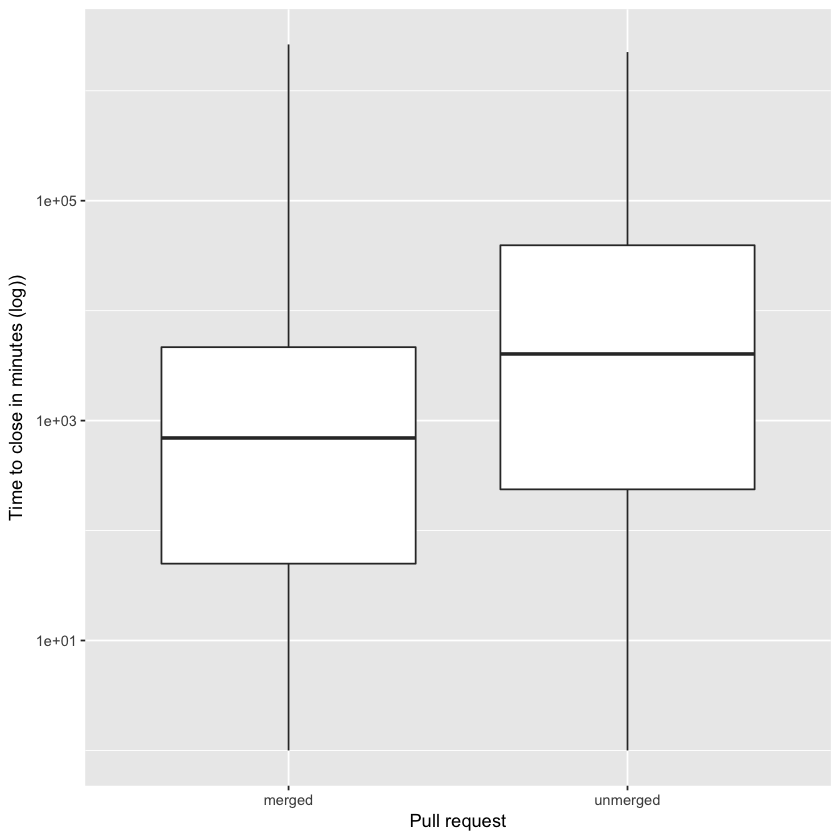

In [28]:
ggplot(lifetimes, aes(x = type, y = lifetime_minutes)) +
  geom_boxplot()  + scale_y_log10() + xlab("Pull request") +
  ylab("Time to close in minutes (log))")

ranksum(merged$lifetime_minutes, non_merged$lifetime_minutes,
        "Lifetime of merged and unmerged pull requests")

In [26]:
merged.fast

,X,pull_req_id,project_name,lang,github_id,created_at,merged_at,closed_at,lifetime_minutes,mergetime_minutes,⋯,prior_interaction_issue_comments,prior_interaction_pr_events,prior_interaction_pr_comments,prior_interaction_commits,prior_interaction_commit_comments,first_response,prior_interaction_comments,prior_interaction_events,has_ci,merged
2,2,7118732,0xc0170/project_generator,python,113,1429115903,1429115937,1429115937,0,0,⋯,126,45,6,192,0,-1,132,268,TRUE,TRUE
4,4,7067381,0xc0170/project_generator,python,110,1428841052,1428841169,1428841169,1,1,⋯,118,41,6,182,0,-1,124,253,TRUE,TRUE
8,8,6995256,0xc0170/project_generator,python,102,1428423121,1428424525,1428424525,23,23,⋯,108,34,6,167,0,-1,114,226,TRUE,TRUE
10,10,6975334,0xc0170/project_generator,python,99,1428325280,1428327186,1428327186,31,31,⋯,10,2,0,3,0,-1,10,6,TRUE,TRUE
13,13,6909388,0xc0170/project_generator,python,88,1427863478,1427864653,1427864653,19,19,⋯,33,25,3,48,1,0,37,73,TRUE,TRUE
15,15,6836217,0xc0170/project_generator,python,86,1427381214,1427381555,1427381555,5,5,⋯,33,21,3,44,1,-1,37,65,TRUE,TRUE
17,17,6810736,0xc0170/project_generator,python,84,1427235095,1427235105,1427235105,0,0,⋯,70,23,5,117,0,-1,75,158,TRUE,TRUE
18,18,6810504,0xc0170/project_generator,python,83,1427234046,1427234505,1427234505,7,7,⋯,31,20,3,43,1,-1,35,63,TRUE,TRUE
20,20,6791083,0xc0170/project_generator,python,80,1427137735,1427139877,1427139877,35,35,⋯,30,18,3,26,1,-1,34,44,TRUE,TRUE
22,22,6775847,0xc0170/project_generator,python,78,1427051338,1427051953,1427051953,10,10,⋯,30,14,1,24,1,-1,32,38,TRUE,TRUE
